<a href="https://colab.research.google.com/github/Dukhkasht/ML-and-DL-prjects/blob/main/tamatar_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the dataset from kaggle for classification

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshbajetha","key":"49c714935d4d99b2dd2ef97e02ced303"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                         Student Performance Predictions                      9KB  2024-08-17 06:57:57           3438         81  0.9411765        
mrmars1010/filpkart-mobiles                                          Flipkart Products Sales: Mobiles Dataset 📱         108KB  2024-08-24 04:31:50           1039         25  0.88235295       
haseebindata/global-population-growth-2024                           Global Population Growth 2024                       20KB  2024-08-21 05:32:16           1230         24  0.88235295       
berkayalan/paris-2024-olympics-medals   

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 98% 323M/329M [00:02<00:00, 133MB/s]
100% 329M/329M [00:02<00:00, 123MB/s]


In [ ]:
! unzip plant-village.zip -d 'plant village'

Streaming output truncated to the last 5000 lines.
  inflating: plant village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plant village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-

In [ ]:
! rm -r /content/'plant village'/PlantVillage/P*

In [ ]:
! mv 'plant village' 'training'

## Starting the classification model creation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models

In [ ]:
# importing images into the tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/training/PlantVillage",
                                                    shuffle = True,
                                                    image_size = (150,150),
                                                    batch_size = 16
                                                    )

Found 16011 files belonging to 10 classes.


In [ ]:
class_names =  dataset.class_names  # used to find the class name(which are the directory name)

In [ ]:
len(dataset)

1001

In [ ]:
# printing shape of images in each batch and their perspective class
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 150, 150, 3)
[2 9 7 6 7 9 7 5 8 5 2 3 0 7 7 5]


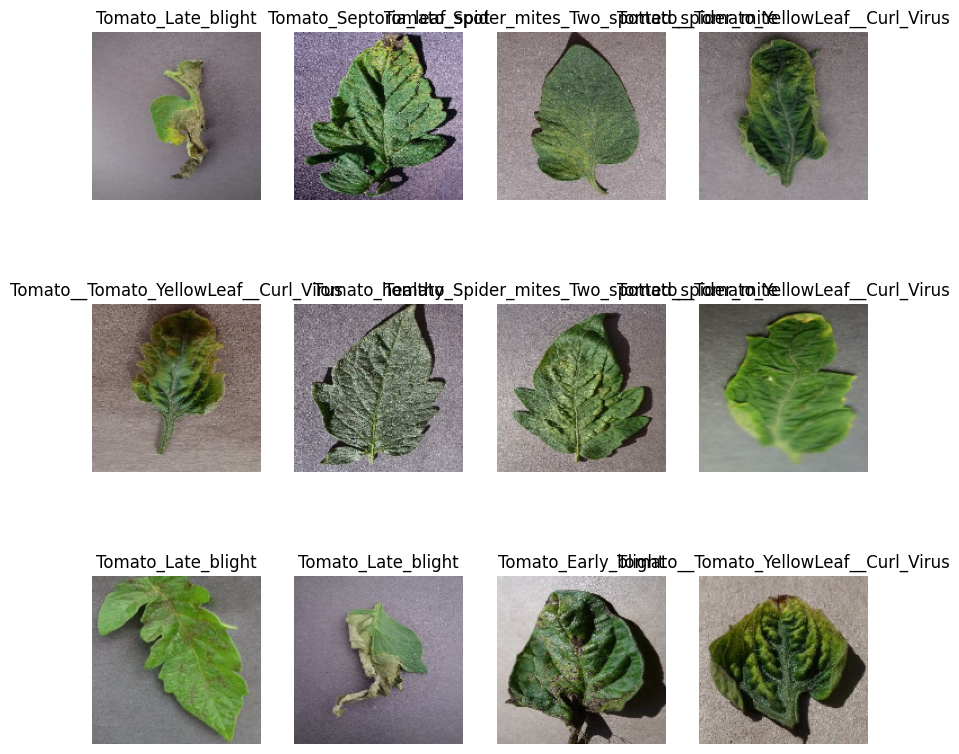

In [ ]:
 # displaying couple of images in dataset
 plt.figure(figsize=(10,10))
 for image_batch,label_batch in dataset.take(1):
    for i in range(12):
      ax = plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis('off')

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

1001

In [ ]:
train_size = 0.8
len(dataset)*train_size

800.8000000000001

In [ ]:
train_ds = dataset.take(400)
len(train_ds)

400

In [ ]:
test_ds = dataset.skip(400)
len(test_ds)

601

In [ ]:
val_size=0.1
len(dataset)*val_size

100.10000000000001

In [ ]:
test_ds = test_ds.skip(50)
len(test_ds)

551

In [ ]:
# creating a function for splitting
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds),len(val_ds),len(test_ds)

(800, 100, 101)

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building model
 Creating a Layer for Resizing and Normalization

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(150, 150),
    layers.Rescaling(1./255),
])

Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
# applying data augmentation to the training dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Convolutional Layer

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(16,150,150,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.build(input_shape=(16,150,150,3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (16, 150, 150, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (16, 148, 148, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (16, 74, 74, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (16, 72, 72, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (16, 36, 36, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (16, 34, 34, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (16, 17, 17, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (16, 15, 15, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (16, 7, 7, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (16, 3136)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (16, 64)                    │         200,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (16, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,666 (1.12 MB)

 Trainable params: 294,666 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

Model Compiling

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size= 16,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 94s 91ms/step - accuracy: 0.3628 - loss: 1.7661 - val_accuracy: 0.7444 - val_loss: 0.7587
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - accuracy: 0.7230 - loss: 0.8072 - val_accuracy: 0.7750 - val_loss: 0.6206
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - accuracy: 0.7991 - loss: 0.5615 - val_accuracy: 0.7800 - val_loss: 0.6042
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 53s 66ms/step - accuracy: 0.8453 - loss: 0.4379 - val_accuracy: 0.8213 - val_loss: 0.4818
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step - accuracy: 0.8693 - loss: 0.3736 - val_accuracy: 0.8825 - val_loss: 0.3527
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - accuracy: 0.8910 - loss: 0.3076 - val_accuracy: 0.8806 - val_loss: 0.2891
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 50s 62ms/step - accuracy: 0.8983 - loss: 0.2955 - val_accuracy: 0.9169 - val_loss: 0.2228
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - accuracy: 0.9113 - loss: 0.2520 - 

In [ ]:
scores = model.evaluate(test_ds)

101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9308 - loss: 0.2017


In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

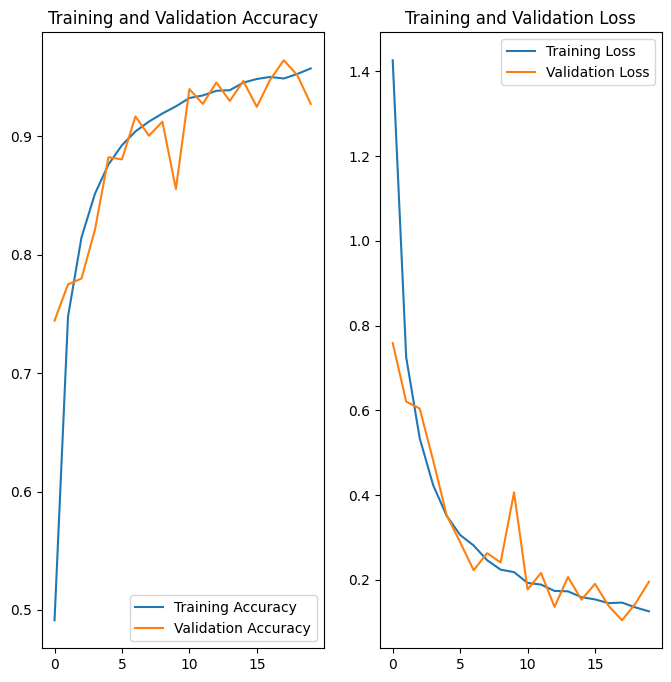

In [ ]:
# plotting the accuracy and loss curve
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Running prediction

first image to predict
actual label: Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
predicted label: Tomato_healthy


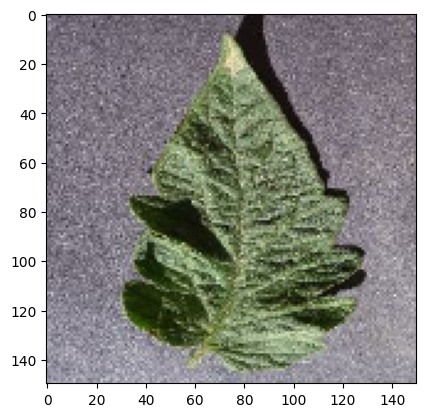

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Saving the model

In [ ]:
model.save('tamatar.keras')